# Ex3. Siamese networks and zero-shot learning

### Redis
I have identified reading image files of disk as a significant bottleneck in model training. I have addressed this by loading the images in a in-memory database called redis, that offer persistence by storing the entire database as a single file on the hard-drive. This has significantly sped up training times.

### Transfer learning
In this exercise I use the inception network as a base for my siamese network. In an earlier exercise I had problems getting good performance from this approach. This time I managed to make the model perform better on the dataset. I attribute this to two steps taken:
    - I add a batch normalization layer before inception input layer.
    - I use the tensorflow.keras implementation instead of the "default" keras implementation.
I strongly suspect that my problems with transfer learning in the earlier exercise is related to the problems discussed in the followng blog-post: https://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/ or some variation related to the problems discussed therein.

### Custom loss function
In this assignment I consider two siamese networks. One standard using the std_triplet_loss function, that is:
$$\mathcal{L} = \max(d_{pos}^2+ \alpha - d_{neg}^2, 0)$$,
where $d_{pos}$ and $d_{neg}$ is the distance between the positive and negative example and the anchor respectively, and $\alpha$ is some hyperparameter. The second is my variation using a taxonomic loss function that uses the following loss function:
$$\mathcal{L} = d_{pos}+ \alpha|d_{true} - d_{neg}|$$,
where $d_{true}$ is the true distance between the anchor and the negative example as indicated by the taxonomic tree of the ZooScanSet dataset. As a distance metric I use the taxonomic distance as defined in: http://www.coastalwiki.org/wiki/Measurements_of_biodiversity, that is, the path between two leafes of a phylogenetic tree. This metric conforms to the triangle inequality.


## Finding embedding
I first train the inception model on the training dataset. After 25 epochs each training 20*1000 images I get an accuracy of about 87%.

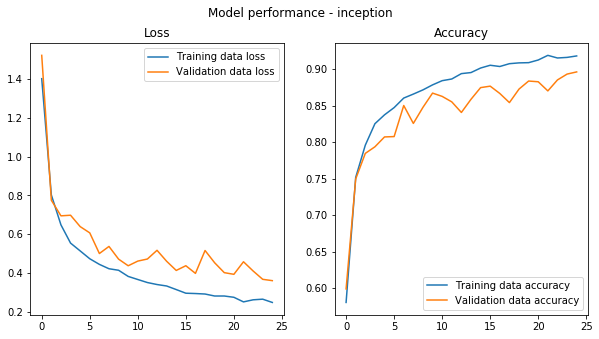

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("history_trained_"+C.base_model)

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training data loss')
    plt.plot(history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='Training data accuracy')
    plt.plot(history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(C.base_model))
    plt.show()
plot_history(df)

I then use the trained inception model as a base in a siamese network. I train two variations of this network, each using one of the loss functions presented earlier. First let me present the functions used to visualize the embeddings:

In [1]:
from create_siamese_model import initialize_bitvector_model, model_path
import pandas as pd
from tensorflow.keras.models import load_model
from generators import Singlet
import config as C
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from read_hierarchy import taxonomic_grouping, taxonomic_path, taxonomic_ordering
import plotly.offline as pyo

import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()


def make_taxonomic_distance_plot(X_2d, y):
    j = 13
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('afmhot')
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(taxonomic_ordering(name))])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    pyo.iplot(fig)

    
def make_uniqueness_plot(X_2d, y):
    j = 13
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('hsv', 40)
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(i)])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    pyo.iplot(fig)
    
    
def get_embedding(model):
    nrSamples = 1000
    datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=nrSamples)
    imgs = []
    labels = []
    embeddings = []
    for i in range(nrSamples):
        X, y = datagen[i]
        imgs.append(X)
        labels.append(y)
        embeddings.append(bitvector_model.predict_on_batch(X))

    X = np.stack(embeddings).reshape((nrSamples, C.out_dim))
    y = np.asarray(labels).reshape((nrSamples,))
    
    tsne = TSNE(n_components=2, random_state=0, n_iter=3000)
    X_2d_tsne = tsne.fit_transform(X)
    
    mds = MDS(n_components=2)
    X_2d_mds = mds.fit_transform(X.astype(np.float64))
    
    return X, X_2d_tsne, X_2d_mds, y


It is clear from the following plot that when I use the std_triplet_loss function I get an embedding that produces clusters that are more or less unique for each of the classes.

In [2]:
bitvector_model = load_model(model_path("bitvector_"+C.base_model))
bitvector_X, bitvector_X_2d_tsne, bitvector_X_2d_mds, bitvector_y = get_embedding(bitvector_model)
#X_2d = np.load('b_X_2d.npy')
#y = np.load('b_y.npy')



Instructions for updating:
Colocations handled automatically by placer.


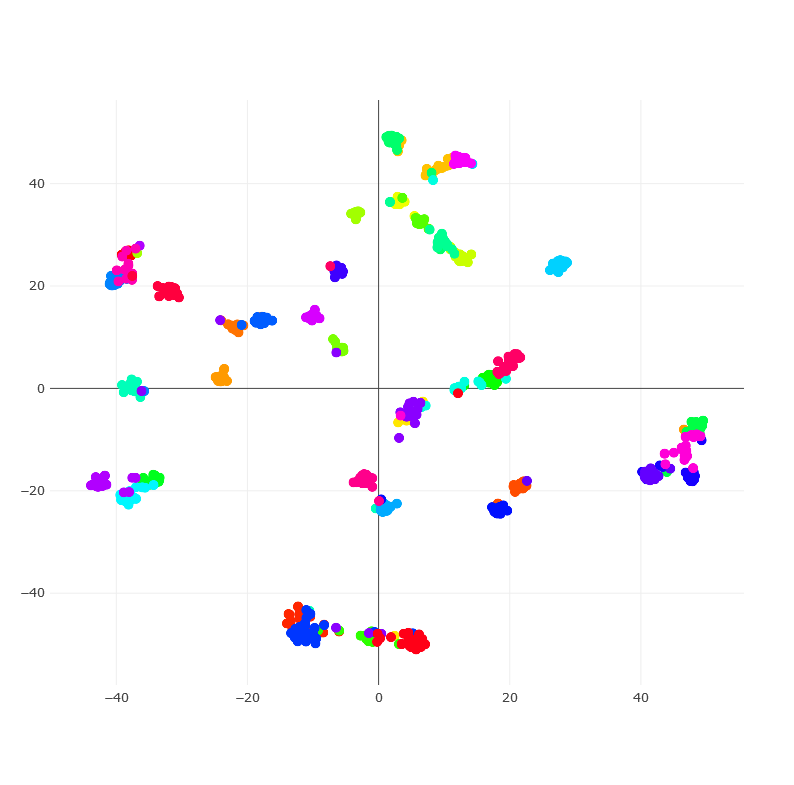

In [4]:
make_uniqueness_plot(bitvector_X_2d_tsne, bitvector_y)

However from the following plot we see that the taxonomic distance between the classes is not preserved in the embedding:

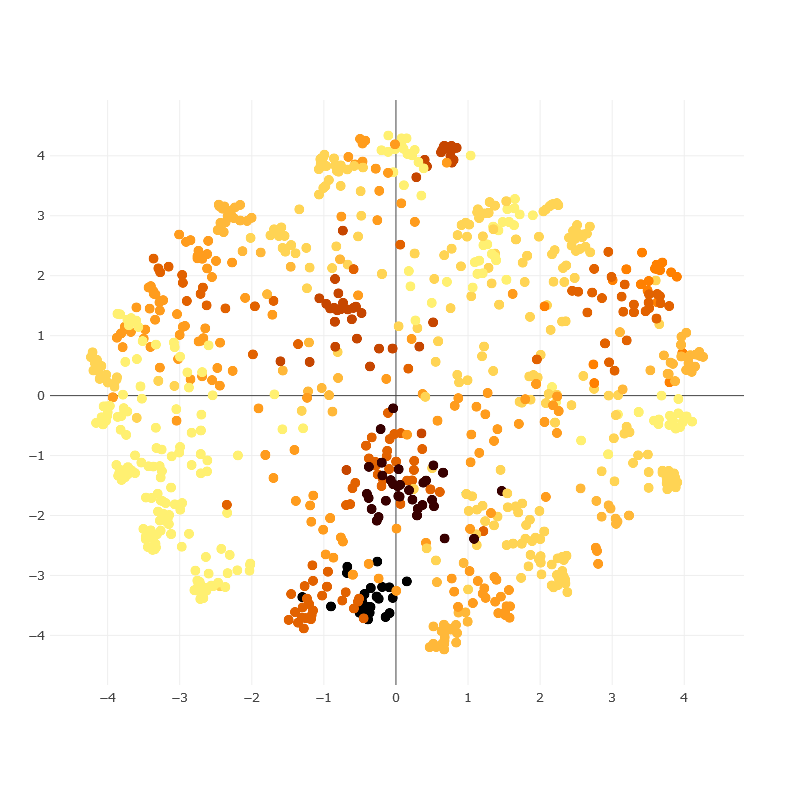

In [5]:
make_taxonomic_distance_plot(bitvector_X_2d_mds, bitvector_y)

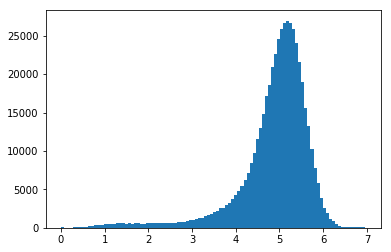

In [53]:
distances = []

for i in range(len(bitvector_X)-1):
    for j in range(i+1, len(bitvector_X)):
        distances.append(np.linalg.norm(bitvector_X[i]-bitvector_X[j]))
plt.hist(distances, bins=100)
plt.show()

Now lets consider embedding found when using the loss function that takes advantag of the taxonomic distance between the classes. We see that it produced unique clusters:

In [54]:
hierarchy_bitvector_model = load_model(model_path("hierachy_bitvector_"+C.base_model))
hierachy_bitvector_X, hierachy_bitvector_X_2d_tsne, hierachy_bitvector_X_2d_mds, hierachy_bitvector_y = get_embedding(bitvector_model)
#X_2d = np.load('hb_X_2d.npy')
#y = np.load('hb_y.npy')

#make_uniqueness_plot(X_2d, y)

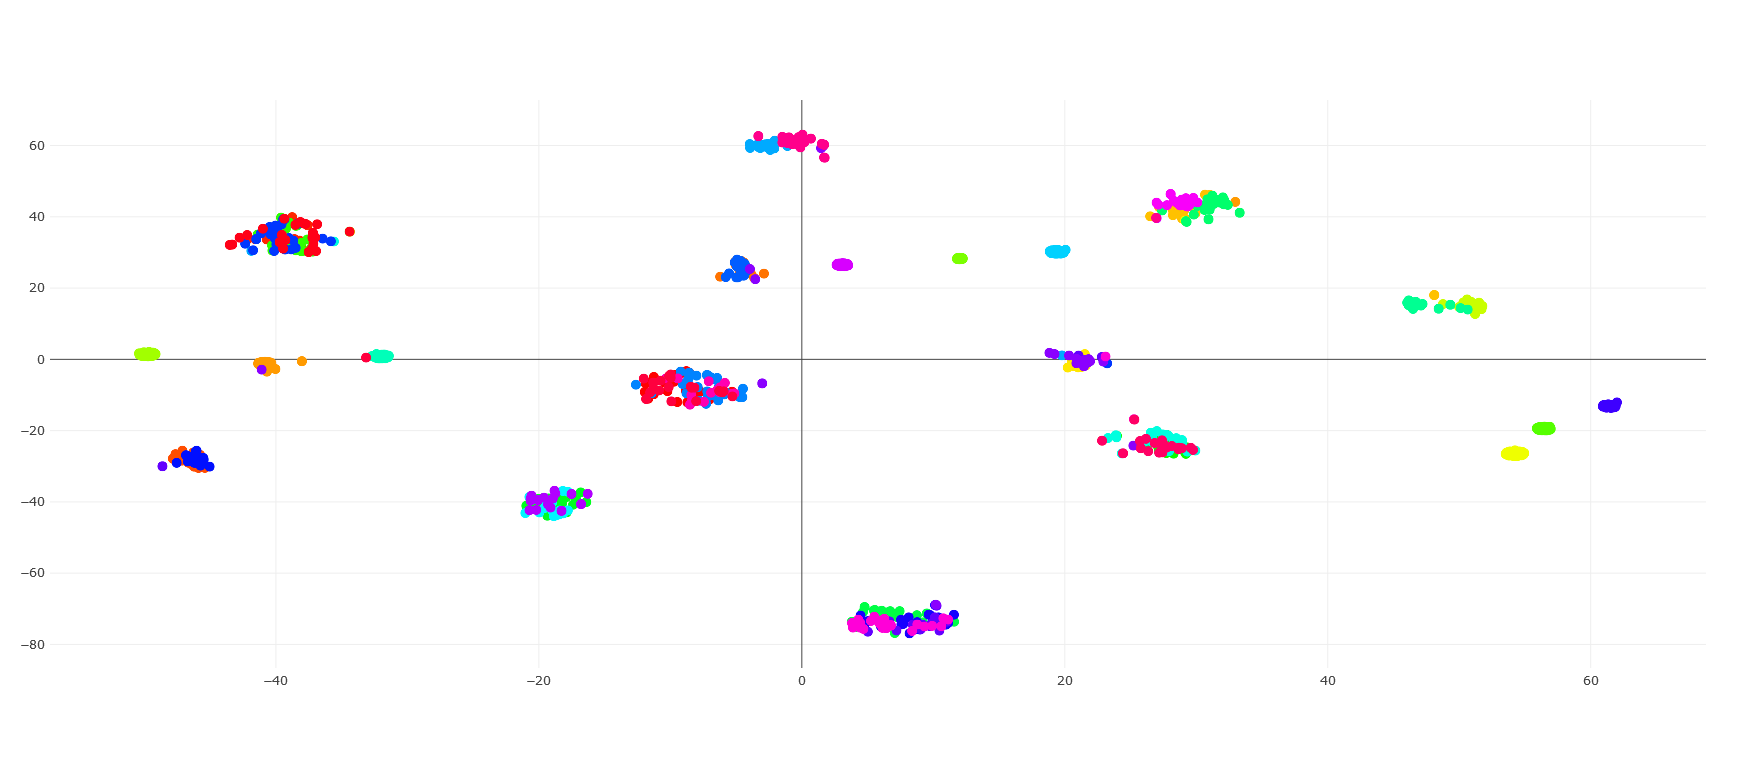

In [55]:
make_uniqueness_plot(hierachy_bitvector_X_2d_tsne, hierachy_bitvector_y)

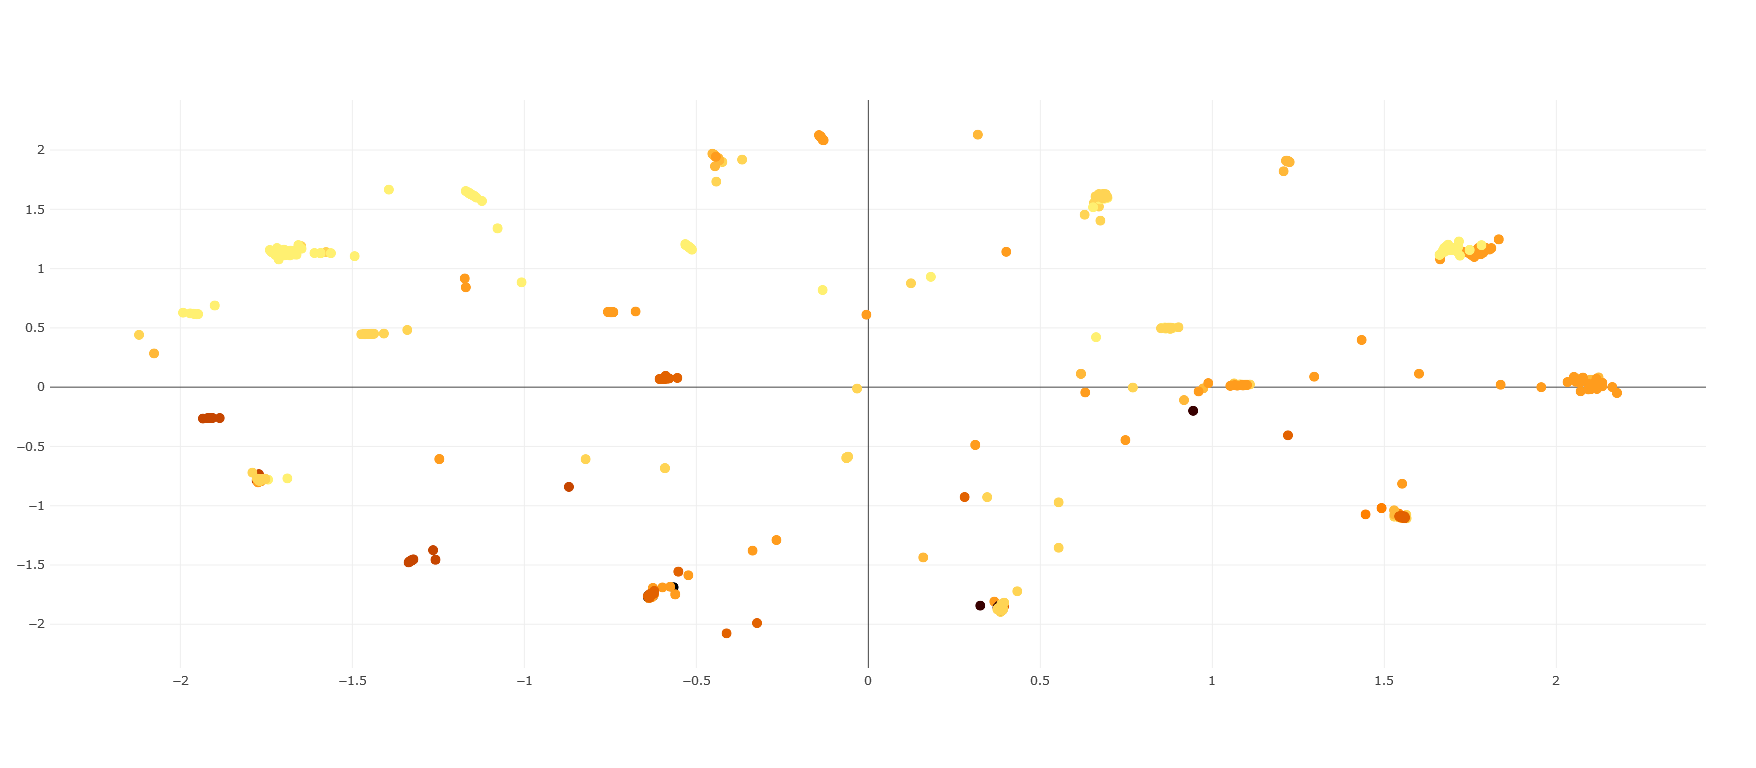

In [56]:
make_taxonomic_distance_plot(hierachy_bitvector_X_2d_mds, hierachy_bitvector_y)

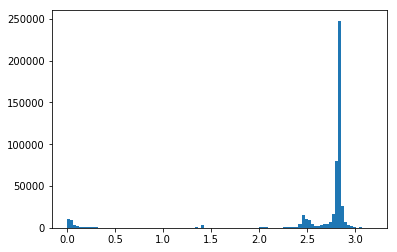

In [57]:
distances = []

for i in range(len(hierachy_bitvector_X)-1):
    for j in range(i+1, len(hierachy_bitvector_X)):
        distances.append(np.linalg.norm(hierachy_bitvector_X[i]-hierachy_bitvector_X[j]))
plt.hist(distances, bins=100)
plt.show()

And the plot of the MSE dimensionality reduction shows that the distance between the taxonomic classes is preserved in the embedding:

## Classifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier
embedding_1_classifier = KNeighborsClassifier(n_neighbors=3).fit(bitvector_X, bitvector_y)
embedding_1_classifier.score(bitvector_X, bitvector_y)

0.913

In [59]:
embedding_2_classifier = KNeighborsClassifier(n_neighbors=3).fit(hierachy_bitvector_X, hierachy_bitvector_y)
embedding_2_classifier.score(hierachy_bitvector_X, hierachy_bitvector_y)

0.823

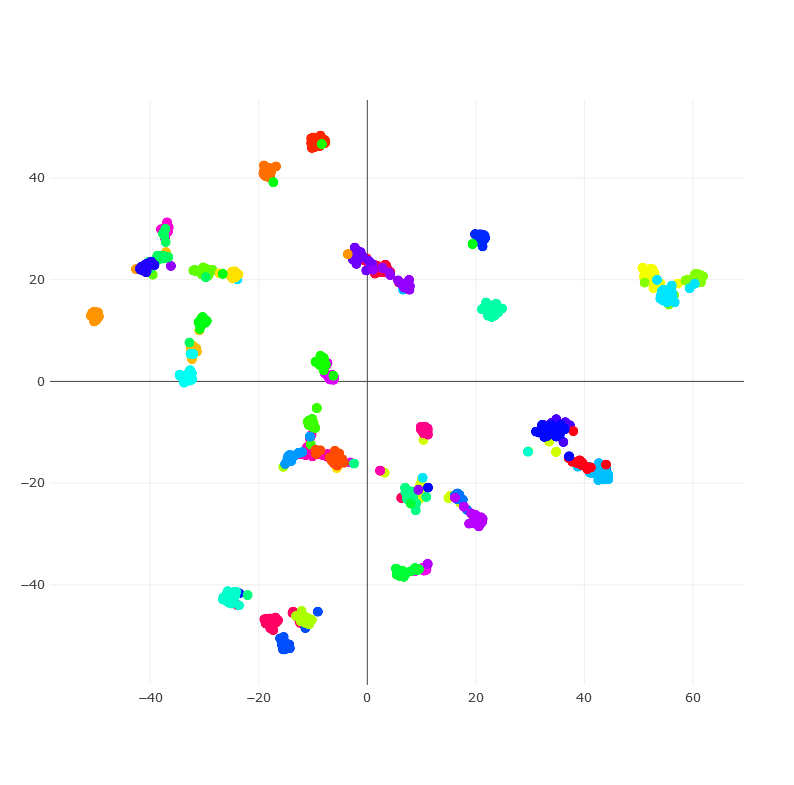

In [6]:
import matplotlib.pyplot as plt
from read_hierarchy import taxonomic_grouping, taxonomic_path, taxonomic_ordering
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
# Create traces

def myOr(ls_vec):
    if len(ls_vec)==1:
        return ls_vec[0]
    else:
        return ls_vec[0] | myOr(ls_vec[1:])

def make_plot(j):
    groups = taxonomic_grouping(j)
    rev_groups = {}
    for key, val in groups.items():
        if val in rev_groups:
            rev_groups[val].append(key)
        else:
            rev_groups[val] = [key]
    
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('hsv', len(sets)+1)
    
    data = []
    for (g, name), vals in rev_groups.items():
        mask = myOr([y==i for i in vals])
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(g+1)])
        obj = go.Scattergl(
            x=X_2d[mask, 0],
            y= X_2d[mask, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = name,
            showleg
        )
        
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    pyo.iplot(fig)

make_plot(13)